In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch .utils.data import  DataLoader
from torchvision.transforms import ToTensor,Resize, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import shutil
from skimage.transform import resize
from matplotlib import image as mpimg
from torch.utils.data import random_split



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!git clone https://github.com/adamczycha/HPT.git

Cloning into 'HPT'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 144 (delta 41), reused 57 (delta 26), pack-reused 70
Receiving objects: 100% (144/144), 161.91 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Updating files: 100% (83/83), done.


In [4]:
batch_size = 8
length_limit = 3
num_of_words = 30

In [5]:
source_files = 'HPT/author'
end_directory = 'train_data'
root_dir = ''
model_save_dir = 'models'


In [6]:
os.chdir("HPT")
from ImagePreparation import ImagePreparation as IP
from ModelEvaluation import ModelEvaluation as ME
os.chdir('..')

In [7]:
image_prep = IP(end_directory, source_files)
image_prep.prepare_images()
image_prep.remove_words_over_limit(num_of_words,word_length_limit = length_limit)

Deleted 53 folders because of additional characters
[(154, 'się'), (118, 'nie'), (102, 'jest'), (66, 'jak'), (64, 'oraz'), (54, 'lecz'), (52, 'był'), (47, 'tym'), (47, 'przez'), (47, 'może'), (46, 'widać'), (46, 'przed'), (41, 'danych'), (40, 'jego'), (37, 'domu'), (36, 'być'), (33, 'też'), (32, 'same'), (28, 'tylko'), (28, 'pod'), (27, 'które'), (27, 'gdzie'), (26, 'była'), (25, 'lub'), (25, 'jako'), (24, 'tych'), (24, 'tak'), (24, 'stary'), (24, 'przy'), (24, 'nim')]
Deleted 3967 folders because of length limit and lack of occurences


In [8]:
transformation = transforms.Compose([Resize((224,224)),
                                 ToTensor(),
                                 transforms.Grayscale(3),
                                 Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [9]:
full_data = ImageFolder(root = os.path.join(root_dir, 'train_data'),
                         transform = transformation)
_generator = torch.Generator().manual_seed(42)
train_data, test_data = torch.utils.data.random_split(full_data,[0.8,0.2],generator =_generator)

In [10]:
idx_to_class = {j:i for i, j in full_data.class_to_idx.items()}

Text(0.5, 1.0, 'być')

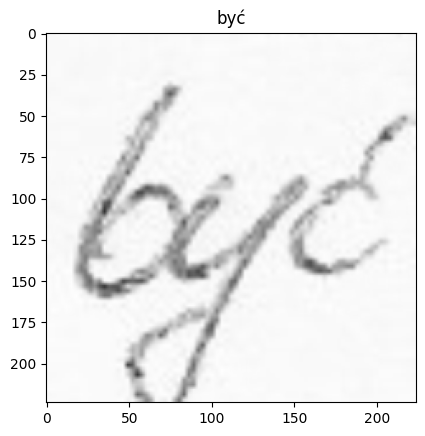

In [11]:
sample_img = full_data[0][0].numpy().transpose(1,2,0)
mean = np.array([0.5,0.5,0.5])
std = np.array([0.5,0.5,0.5])
inp = std * sample_img + mean
inp = np.clip(inp,0,1)
plt.imshow(inp)
plt.title(idx_to_class[(full_data[0][1])])

In [12]:
def data_loader_init(batch_size):
    train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
    test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle=True, num_workers = 0)
    return train_dataloader, test_dataloader

In [13]:
class block(nn.Module):
    def __init__(self, in_channels, intermidate_channels, identity_downsample = None, stride = 1):
        super().__init__()
        self.expantion = 4
        self.conv1 = nn.Conv2d(in_channels,intermidate_channels, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(intermidate_channels)
        self.conv2 = nn.Conv2d(intermidate_channels,intermidate_channels,kernel_size=3, stride = stride, padding = 1, bias = False )
        self.bn2 = nn.BatchNorm2d(intermidate_channels)
        self.conv3 = nn.Conv2d(intermidate_channels, intermidate_channels*4, kernel_size = 1, bias = False )
        self.bn3 = nn.BatchNorm2d(intermidate_channels*4)
        self.identity_downsample = identity_downsample
        self.stride = stride


    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x = x + identity
        x = F.relu(x)
        return x





In [14]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels,self.in_channels, kernel_size = 7, stride=2, padding= 3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)

        self.layer1 = self._make_layer(block, layers[0], 64, 1)
        self.layer2 = self._make_layer(block, layers[1], 128, 2)
        self.layer3 = self._make_layer(block, layers[2], 256, 2)
        self.layer4 = self._make_layer(block, layers[3], 512, 2)

        self.fc1 = nn.Linear(512*4, num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding =1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x,(1,1))
        x = x.flatten(1)
        x = self.fc1(x)
        return x


    def _make_layer(self, block, num_residual_blocks, intermidate_channels, stride):
        identity_downsample= None
        layers = []

        if stride != 1 or self.in_channels != (intermidate_channels*4):
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermidate_channels*4, stride=stride, kernel_size= 1, bias = False),
                nn.BatchNorm2d(intermidate_channels *4)
            )

        layers.append(
            block(self.in_channels,intermidate_channels, identity_downsample, stride)
            )

        self.in_channels = intermidate_channels *4

        for i in range(num_residual_blocks -1):
            layers.append(block(self.in_channels, intermidate_channels))

        return nn.Sequential(*layers)


In [15]:
def ResNet50(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,4,6,3], img_channel, num_classes)

def ResNet101(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,4,23,3], img_channel, num_classes)

def ResNet152(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,8,36,3], img_channel, num_classes)



In [16]:
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)

In [17]:
general_params = {'img_channel': 3,'num_classes': num_of_words,'lr': 1e-4,'scheduler_step':10,'scheduler_gamma':0.1}

# train_param = [ {'model':ResNet50,'model_name':'ResNet50','batch_size': 8 },{'model':ResNet50,'model_name':'ResNet50','batch_size': 16},{'model':ResNet50,'model_name':'ResNet50','batch_size': 32},
#                    {'model':ResNet101,'model_name':'ResNet101','batch_size':8 },{'model':ResNet101,'model_name':'ResNet101','batch_size': 16 },{'model':ResNet101,'model_name':'ResNet101','batch_size': 32 }]
train_param = [ {'model':ResNet101,'model_name':'ResNet101','batch_size': 4} ]

--------------------------------------------------
Model ResNet101 with a batch size of 4.
--------------------------------------------------
Epoch 1/22
----------
train loss: 1.2413648070810048, acc: 0.15251141786575317
test loss: 1.5097894773378477, acc: 0.12820513546466827
Epoch 2/22
----------
train loss: 0.9146308859733686, acc: 0.25479450821876526
test loss: 1.0491378080277216, acc: 0.2271062284708023
Epoch 3/22
----------
train loss: 0.4286831183996919, acc: 0.5287671089172363
test loss: 0.5763363755229629, acc: 0.45787546038627625
Epoch 4/22
----------
train loss: 0.258530206418677, acc: 0.6858447194099426
test loss: 0.3949943798280324, acc: 0.5567765831947327
Epoch 5/22
----------
train loss: 0.32389035605013233, acc: 0.6794520616531372
test loss: 0.47240822065635263, acc: 0.5824176073074341
Epoch 6/22
----------
train loss: 0.11804381976814167, acc: 0.8639269471168518
test loss: 0.2956658061662, acc: 0.7289377450942993
Epoch 7/22
----------
train loss: 0.1704463900661215, acc

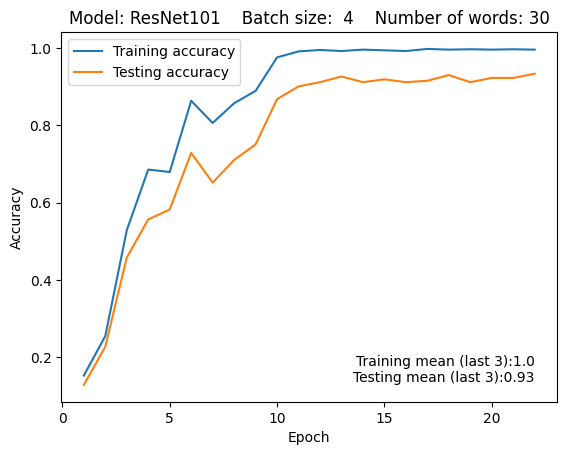

In [18]:
meval = ME(general_params, weights_init)
n_epochs = 22
for param in train_param:
    print('-'*50)
    print(f"Model {param['model_name']} with a batch size of {param['batch_size']}.")
    print('-'*50)
    train_loader, test_loader = data_loader_init(param['batch_size'])
    meval.train_model(n_epochs, param, train_loader, test_loader)
